<a href="https://colab.research.google.com/github/mwhite270/Chronos-2/blob/main/Ethereum_Forecasting_Using_Chronos_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ETHEREUM FORECASTING USING CHRONOS-2**

*   Observe performance of ethereum forecasting using Amazon Science's Chronos-2.
*   Use eth price data from coingecko

[Chronos-2 Site](https://www.amazon.science/blog/introducing-chronos-2-from-univariate-to-universal-forecasting)


# Install and import packages

In [34]:
!pip install "chronos-forecasting>=2.0" --quiet

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from chronos import Chronos2Pipeline

import warnings
warnings.filterwarnings("ignore")

# Data loading and dataframe cleansing.

Pricing data comes from coingecko.

In [36]:
pipeline = Chronos2Pipeline.from_pretrained("amazon/chronos-2", device_map="cpu") # Pre-trained model pull

In [37]:
# https://www.coingecko.com/en/coins/ethereum

eth_df = pd.read_csv("/content/Data/eth-usd-max.csv", parse_dates=["snapped_at"])
eth_df.head()

,snapped_at,price,market_cap,total_volume
0,2015-08-07 00:00:00+00:00,2.831620,0.000000e+00,9.062200e+04
1,2015-08-08 00:00:00+00:00,1.330750,8.033948e+07,3.680700e+05
2,2015-08-10 00:00:00+00:00,0.687586,4.155631e+07,4.004641e+05
3,2015-08-11 00:00:00+00:00,1.067379,6.453901e+07,1.518998e+06
4,2015-08-12 00:00:00+00:00,1.256613,7.601326e+07,2.073893e+06


In [38]:
# Dropping unneeded columns.
eth_df = eth_df.drop(['market_cap','total_volume'], axis = 1)

# Make 'snapped_at' a datetime index since Chronos-2 was unable to infer frequrency when I first tried
eth_df = eth_df.set_index('snapped_at').asfreq('D')

# Fill any NaN values created by asfreq with previous and then next valid observation
eth_df['price'] = eth_df['price'].ffill().bfill()

# Creating an identifier column
eth_df['id']= 'eth'

# Reset the index to make 'snapped_at' a column again
eth_df = eth_df.reset_index()

eth_df.head()

,snapped_at,price,id
0,2015-08-07 00:00:00+00:00,2.831620,eth
1,2015-08-08 00:00:00+00:00,1.330750,eth
2,2015-08-09 00:00:00+00:00,1.330750,eth
3,2015-08-10 00:00:00+00:00,0.687586,eth
4,2015-08-11 00:00:00+00:00,1.067379,eth


# Chronos-2 Evaluation

In [39]:
# future_df = eth_df.drop(columns="price") # Setting a future dataframe, but I didn't use this
# future_df.tail()

In [40]:
context_df = eth_df.iloc[:-24] # Use all but last 24 days of data for training
context_df.tail()

,snapped_at,price,id
3722,2025-10-15 00:00:00+00:00,4128.888447,eth
3723,2025-10-16 00:00:00+00:00,3983.154436,eth
3724,2025-10-17 00:00:00+00:00,3890.199301,eth
3725,2025-10-18 00:00:00+00:00,3831.244176,eth
3726,2025-10-19 00:00:00+00:00,3889.499030,eth


In [41]:
test_df = eth_df.iloc[-24:] # Last 24 days of data for testing/evaluation
test_df.tail()

,snapped_at,price,id
3746,2025-11-08 00:00:00+00:00,3434.351229,eth
3747,2025-11-09 00:00:00+00:00,3401.459400,eth
3748,2025-11-10 00:00:00+00:00,3576.254705,eth
3749,2025-11-11 00:00:00+00:00,3564.610596,eth
3750,2025-11-12 00:00:00+00:00,3416.781328,eth


In [42]:
prediction_length = 24 # Setting the prediction length to 24 days

In [43]:
pred_df = pipeline.predict_df(
    context_df,
    #future_df=future_df,
    prediction_length=prediction_length,  # Use the defined prediction length
    quantile_levels=[0.1, 0.5, 0.9],  # Quantiles for probabilistic forecast
    id_column="id",  # Column identifying different time series
    timestamp_column="snapped_at",  # Column with datetime information
    target="price",  # Column(s) with time series values to predict
)

In [44]:
pred_df.tail()

,id,snapped_at,target_name,predictions,0.1,0.5,0.9
19,eth,2025-11-08 00:00:00+00:00,price,3849.095703,3213.979980,3849.095703,4552.516602
20,eth,2025-11-09 00:00:00+00:00,price,3857.401367,3198.365723,3857.401367,4538.088867
21,eth,2025-11-10 00:00:00+00:00,price,3834.249512,3172.034912,3834.249512,4567.347656
22,eth,2025-11-11 00:00:00+00:00,price,3840.963867,3155.777344,3840.963867,4584.119629
23,eth,2025-11-12 00:00:00+00:00,price,3848.492676,3143.897949,3848.492676,4614.869629


In [45]:
# Visualization helper function

def plot_forecast(
    context_df: pd.DataFrame,
    pred_df: pd.DataFrame,
    test_df: pd.DataFrame,
    target_column: str,
    timeseries_id: str,
    id_column: str = "id",
    timestamp_column: str = "snapped_at",
    history_length: int = 256,
    title_suffix: str = "",
):
    ts_context = context_df.query(f"{id_column} == @timeseries_id").set_index(timestamp_column)[target_column]
    ts_pred = pred_df.query(f"{id_column} == @timeseries_id and target_name == @target_column").set_index(
        timestamp_column
    )[["0.1", "predictions", "0.9"]]
    ts_ground_truth = test_df.query(f"{id_column} == @timeseries_id").set_index(timestamp_column)[target_column]

    last_date = ts_context.index.max()
    start_idx = max(0, len(ts_context) - history_length)
    plot_cutoff = ts_context.index[start_idx]
    ts_context = ts_context[ts_context.index >= plot_cutoff]
    ts_pred = ts_pred[ts_pred.index >= plot_cutoff]
    ts_ground_truth = ts_ground_truth[ts_ground_truth.index >= plot_cutoff]

    fig = plt.figure(figsize=(12, 3))
    ax = fig.gca()
    ts_context.plot(ax=ax, label=f"historical {target_column}", color="xkcd:azure")
    ts_ground_truth.plot(ax=ax, label=f"future {target_column} (ground truth)", color="xkcd:grass green")
    ts_pred["predictions"].plot(ax=ax, label="forecast", color="xkcd:violet")
    ax.fill_between(
        ts_pred.index,
        ts_pred["0.1"],
        ts_pred["0.9"],
        alpha=0.7,
        label="prediction interval",
        color="xkcd:light lavender",
    )
    ax.axvline(x=last_date, color="black", linestyle="--", alpha=0.5)
    ax.legend(loc="upper left")
    ax.set_title(f"{target_column} forecast for {timeseries_id} {title_suffix}")
    fig.show()

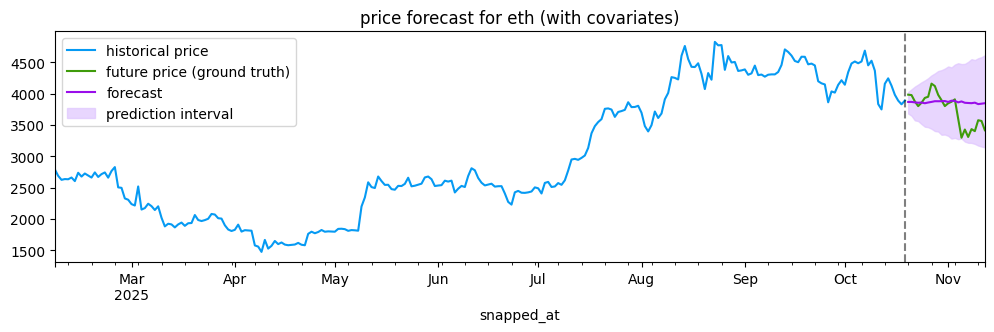

In [46]:
# Visualize forecast with covariates
plot_forecast(
    context_df,
    pred_df,
    test_df,
    target_column="price",
    timeseries_id="eth",
    title_suffix="(with covariates)",
)

The accuracy of the model makes sense considering the markets can be very volatile. Predicting them is difficult!